In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Solve gpu issue for pytorch
# https://discuss.pytorch.org/t/pytorch-1-8-0-fasterrcnn-resnet50-fpn-error/114150/11

In [3]:
import numpy as np
import cv2
import os
import re

# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

/home/yizhou/miniconda3/envs/cliport/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.__version__

'1.11.0'

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
from dataset import HandleDataset, get_train_transform, collate_fn

In [7]:
train_dataset = HandleDataset("/home/yizhou/Research/temp1/", is_train = True, num_frames = 5, \
                              transforms = get_train_transform()) #

val_dataset = HandleDataset("/home/yizhou/Research/temp1/", is_train = False, num_frames = 5, \
                              transforms = get_train_transform()) #

# train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


100%|████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 2994.62it/s]


In [8]:
len(train_dataset)

675

In [9]:
len(val_dataset)

195

In [10]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [11]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


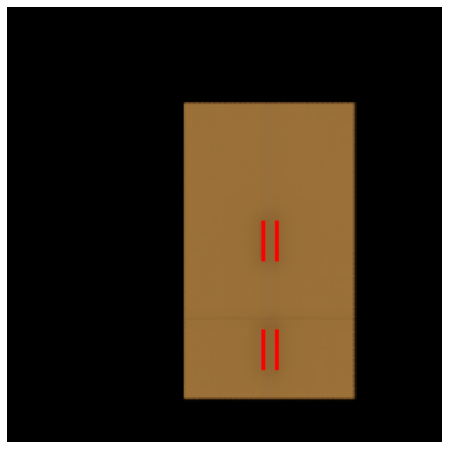

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

In [13]:
len(train_dataset), len(val_dataset)

(675, 195)

# Model

In [14]:
# load a model; pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /home/yizhou/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|███████████████████████████████████████████████████████████████████| 74.2M/74.2M [00:05<00:00, 14.0MB/s]


In [15]:
# torchvision.models.detection.fasterrcnn_resnet50_fpn_v2

AttributeError: module 'torchvision.models.detection' has no attribute 'fasterrcnn_resnet50_fpn_v2'

In [16]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [17]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# Train

In [18]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [19]:
num_epochs = 20

from tqdm.auto import tqdm

best_val_loss = 1e4

In [20]:
model_path = '/home/yizhou/Research/temp0/fasterrcnn_resnet50_fpn907.pth'

In [21]:
loss_hist = Averager()
itr = 1
train_record = []
val_record =  [] 

for epoch in range(num_epochs):
    loss_hist.reset()
    print("epoch", epoch)
    
    # Validation
    model.train()
    # model.eval() #!!!!
    val_loss_list = []
    for images, targets, image_ids in tqdm(val_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        # print("loss_dict", loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        val_loss_list.append(losses.item())
    
    val_loss = np.mean(val_loss_list)
    val_record.append(val_loss)
    print("validation loss: ", val_loss)
    
    if val_loss < best_val_loss:
        
        torch.save(model.state_dict(), model_path)
        best_val_loss = val_loss
    
    # Train
    model.train()
    train_loss_list = []
    for images, targets, image_ids in tqdm(train_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)
        train_loss_list.append(losses.item())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # if itr % 50 == 0:
        #     print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
   
    train_loss = np.mean(train_loss_list)
    train_record.append(train_loss)
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

epoch 0


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.20it/s]


validation loss:  0.8816026867481663


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:09<00:00,  4.51it/s]


Epoch #0 loss: 0.22355565286826093
epoch 1


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 20.15it/s]


validation loss:  0.13335594654547261


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:08<00:00,  5.29it/s]


Epoch #1 loss: 0.20737134560839154
epoch 2


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.07it/s]


validation loss:  0.18813767655293973


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.79it/s]


Epoch #2 loss: 0.28555230806301074
epoch 3


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 22.17it/s]


validation loss:  0.24673509442589062


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.78it/s]


Epoch #3 loss: 0.3347494577055116
epoch 4


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 20.53it/s]


validation loss:  0.2575542061596964


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.88it/s]


Epoch #4 loss: 0.3548960700893652
epoch 5


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.65it/s]


validation loss:  0.3206062228884734


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.84it/s]


Epoch #5 loss: 0.36692234701523696
epoch 6


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 22.16it/s]


validation loss:  0.3608729901850777


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.87it/s]


Epoch #6 loss: 0.365735085598889
epoch 7


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 22.64it/s]


validation loss:  0.3459431151207337


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.64it/s]


Epoch #7 loss: 0.3956508403146537
epoch 8


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 20.29it/s]


validation loss:  0.3947499356613489


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.63it/s]


Epoch #8 loss: 0.42773157118358757
epoch 9


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.22it/s]


validation loss:  0.3915655271747651


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.65it/s]


Epoch #9 loss: 0.4410926788015574
epoch 10


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.16it/s]


validation loss:  0.31829521299796026


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.69it/s]


Epoch #10 loss: 0.43573867417794393
epoch 11


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.21it/s]


validation loss:  0.4059963899226183


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.43it/s]


Epoch #11 loss: 0.4386842248553134
epoch 12


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 19.24it/s]


validation loss:  0.44083891712950046


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.58it/s]


Epoch #12 loss: 0.4566521587549818
epoch 13


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 20.02it/s]


validation loss:  0.3569041127241226


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.80it/s]


Epoch #13 loss: 0.42934885043954024
epoch 14


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.40it/s]


validation loss:  0.36457141946126653


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.54it/s]


Epoch #14 loss: 0.44299896075326406
epoch 15


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.49it/s]


validation loss:  0.38622329529807636


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.65it/s]


Epoch #15 loss: 0.4623325386128385
epoch 16


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.99it/s]


validation loss:  0.4824991376958196


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.76it/s]


Epoch #16 loss: 0.49402979730167096
epoch 17


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.73it/s]


validation loss:  0.37756160775484343


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.79it/s]


Epoch #17 loss: 0.4873495165568775
epoch 18


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 20.54it/s]


validation loss:  0.38569340534541796


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.71it/s]


Epoch #18 loss: 0.5052039908985672
epoch 19


100%|████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.48it/s]


validation loss:  0.4408683036294889


100%|████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.78it/s]


Epoch #19 loss: 0.46313617194400336


In [ ]:
pause

# Validation

In [ ]:
model_path = 
model.load_state_dict(torch.load(model_path))

In [ ]:
images, targets, image_ids = next(iter(val_data_loader))

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Test

In [ ]:
model_path = '/home/yizhou/Research/temp0/fasterrcnn_resnet50_fpn823.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
image_path = "/home/yizhou/Research/temp1/4/rgb_0.png"

In [ ]:
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

In [ ]:
plt.imshow(image)

In [ ]:
images = [torch.tensor(image).permute(2,0,1).to("cuda")]

In [ ]:
images[0].shape

In [ ]:
model.eval()
outputs = model(images)

In [ ]:
boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()

In [ ]:
boxes, scores

In [ ]:
boxes = boxes[scores >= 0.8].astype(np.int32)

In [ ]:
boxes

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(image,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(image)

In [ ]:
def get_bbox_world_position(box, 
       resolution = 256, D = -293, camera_pos = [-1, 0, 0.5], handle_x = 0.61857):
    """
    Calculate the grasp location for the handle

    box: [x_min, y_min, x_max, y_max] 2D boudning box in camera
    resolution: camera resolution
    D: depth of field
    camera_pos: camera_position
    handle_x: object offset

    """
    w_min = box[0] - resolution / 2
    w_max = box[2] - resolution / 2
    h_min = box[1] - resolution / 2
    h_max = box[3] - resolution / 2

    y_max = (handle_x - camera_pos[0]) * w_min / D + camera_pos[1]
    y_min = (handle_x - camera_pos[0]) * w_max / D + camera_pos[1]

    z_max = (handle_x - camera_pos[0]) * h_min / D + camera_pos[2]
    z_min = (handle_x - camera_pos[0]) * h_max / D + camera_pos[2]


    return [y_min, y_max, z_min, z_max]


In [ ]:
get_bbox_world_position(boxes[0])

In [ ]:
boxes[0]